<a href="https://colab.research.google.com/github/Nalendr/ML/blob/main/Ketir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shashwatwork_fruitnet_indian_fruits_dataset_with_quality_path = kagglehub.dataset_download('shashwatwork/fruitnet-indian-fruits-dataset-with-quality')

print('Data source import complete.')


100%|██████████| 3.03G/3.03G [00:47<00:00, 69.0MB/s]

Extracting files...


Data source import complete.


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Define dataset paths
dir = '/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits'
bad_path = os.path.join(dir, 'Bad Quality_Fruits')
good_path = os.path.join(dir, 'Good Quality_Fruits')
mixed_path = os.path.join(dir, 'Mixed Qualit_Fruits')

In [ ]:
# Load image file paths and labels
filepaths, labels = [], []
ht, wt, samples = 0, 0, 0
sample_count = 20

# Use the path from kagglehub
dir = os.path.join(shashwatwork_fruitnet_indian_fruits_dataset_with_quality_path, 'Processed Images_Fruits')

bad_path = os.path.join(dir, 'Bad Quality_Fruits')
good_path = os.path.join(dir, 'Good Quality_Fruits')
mixed_path = os.path.join(dir, 'Mixed Qualit_Fruits')


for quality_path in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality_path)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality_path, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            labels.append(fruit + ('_mixed' if quality_path == mixed_path else ''))

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split dataset into train, validation, and test
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
test_df, valid_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])

# Print dataset details
print(f'Train size: {len(train_df)}, Validation size: {len(valid_df)}, Test size: {len(test_df)}')
classes = train_df['labels'].unique()
print(f'Classes: {classes}')


Train size: 15620, Validation size: 1953, Test size: 1953
Classes: ['Lime_Good' 'Pomegranate_Bad' 'Apple_Bad' 'Orange_Bad' 'Guava_Bad'
 'Banana_mixed' 'Guava_Good' 'Banana_Bad' 'Lime_Bad' 'Apple_Good'
 'Pomegranate_Good' 'Banana_Good' 'Orange_Good' 'Lemon_mixed'
 'Apple_mixed' 'Guava_mixed' 'Pomegranate_mixed' 'Orange_mixed']


In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)
valid_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images using generators
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                                    target_size=(150, 150), batch_size=32, class_mode='categorical')
valid_generator = valid_test_datagen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                                         target_size=(150, 150), batch_size=32, class_mode='categorical')
test_generator = valid_test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                        target_size=(150, 150), batch_size=32, class_mode='categorical')


Found 15620 validated image filenames belonging to 18 classes.
Found 1953 validated image filenames belonging to 18 classes.
Found 1953 validated image filenames belonging to 18 classes.


In [ ]:
# Define CNN model
IMG_SIZE = 150
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')  # Dynamic output neurons based on class count
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import json
history = model.fit(
    train_generator,
    steps_per_epoch=300,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=12
)

# 7. Simpan history training ke JSON
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

# 8. Simpan model ke file .h5
model.save("fruit_quality_model4.h5")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_acc:.4f}')


Epoch 1/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 122s 406ms/step - accuracy: 0.8812 - loss: 0.3546 - val_accuracy: 0.9349 - val_loss: 0.1956
Epoch 2/12
189/300 ━━━━━━━━━━━━━━━━━━━━ 39s 353ms/step - accuracy: 0.8988 - loss: 0.2963

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 77s 259ms/step - accuracy: 0.8968 - loss: 0.3035 - val_accuracy: 0.9201 - val_loss: 0.2387
Epoch 3/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 474ms/step - accuracy: 0.8919 - loss: 0.3217 - val_accuracy: 0.8960 - val_loss: 0.3334
Epoch 4/12
189/300 ━━━━━━━━━━━━━━━━━━━━ 41s 371ms/step - accuracy: 0.8938 - loss: 0.3282

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 81s 272ms/step - accuracy: 0.8952 - loss: 0.3224 - val_accuracy: 0.9355 - val_loss: 0.2088
Epoch 5/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 140s 468ms/step - accuracy: 0.8990 - loss: 0.2947 - val_accuracy: 0.9257 - val_loss: 0.2300
Epoch 6/12
189/300 ━━━━━━━━━━━━━━━━━━━━ 40s 365ms/step - accuracy: 0.9039 - loss: 0.2825

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 79s 265ms/step - accuracy: 0.9046 - loss: 0.2802 - val_accuracy: 0.9319 - val_loss: 0.2107
Epoch 7/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 529ms/step - accuracy: 0.9088 - loss: 0.2742 - val_accuracy: 0.9221 - val_loss: 0.2392
Epoch 8/12
189/300 ━━━━━━━━━━━━━━━━━━━━ 37s 341ms/step - accuracy: 0.9102 - loss: 0.2635

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 248ms/step - accuracy: 0.9101 - loss: 0.2634 - val_accuracy: 0.9288 - val_loss: 0.1882
Epoch 9/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 143s 379ms/step - accuracy: 0.9134 - loss: 0.2681 - val_accuracy: 0.9339 - val_loss: 0.2067
Epoch 10/12
189/300 ━━━━━━━━━━━━━━━━━━━━ 35s 323ms/step - accuracy: 0.9126 - loss: 0.2537

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 241ms/step - accuracy: 0.9108 - loss: 0.2612 - val_accuracy: 0.9273 - val_loss: 0.2237
Epoch 11/12
300/300 ━━━━━━━━━━━━━━━━━━━━ 116s 386ms/step - accuracy: 0.9249 - loss: 0.2287 - val_accuracy: 0.9288 - val_loss: 0.2263
Epoch 12/12
189/300 ━━━━━━━━━━━━━━━━━━━━ 38s 348ms/step - accuracy: 0.9272 - loss: 0.2252

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 249ms/step - accuracy: 0.9267 - loss: 0.2231 - val_accuracy: 0.9467 - val_loss: 0.1572


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9383 - loss: 0.1703
Test Accuracy: 0.9467


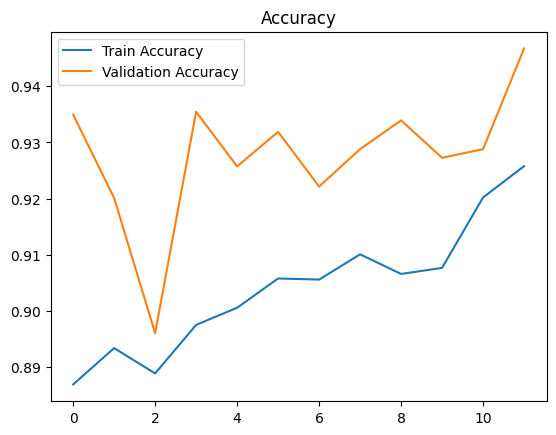

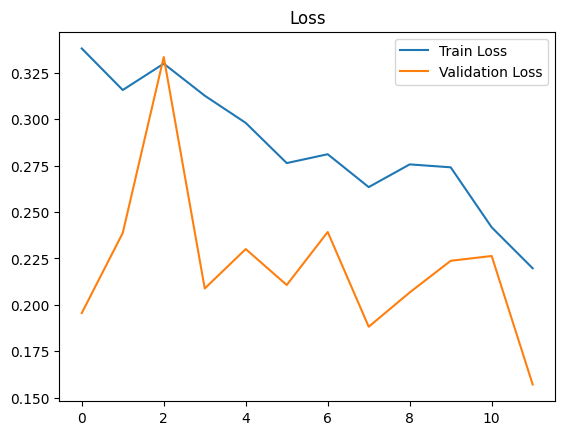

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
image_path="/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits/Guava_Bad/IMG20200728184715.jpg"

In [ ]:
import tensorflow as tf
import numpy as np

def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def predict(image_path):
    # Load the trained model
    model = tf.keras.models.load_model("fruit_quality_model4.h5")

    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Get prediction
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction)

    # Class labels
    class_names = {
        0: 'Apple_Bad', 1: 'Apple_Good', 2: 'Apple_mixed',
        3: 'Banana_Bad', 4: 'Banana_Good', 5: 'Banana_mixed',
        6: 'Guava_Bad', 7: 'Guava_Good', 8: 'Guava_mixed',
        9: 'Lemon_mixed', 10: 'Lime_Bad', 11: 'Lime_Good',
        12: 'Orange_Bad', 13: 'Orange_Good', 14: 'Orange_mixed',
        15: 'Pomegranate_Bad', 16: 'Pomegranate_Good', 17: 'Pomegranate_mixed'
    }

    return class_names.get(predicted_class, "Unknown")

In [ ]:
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted class: Banana_Good


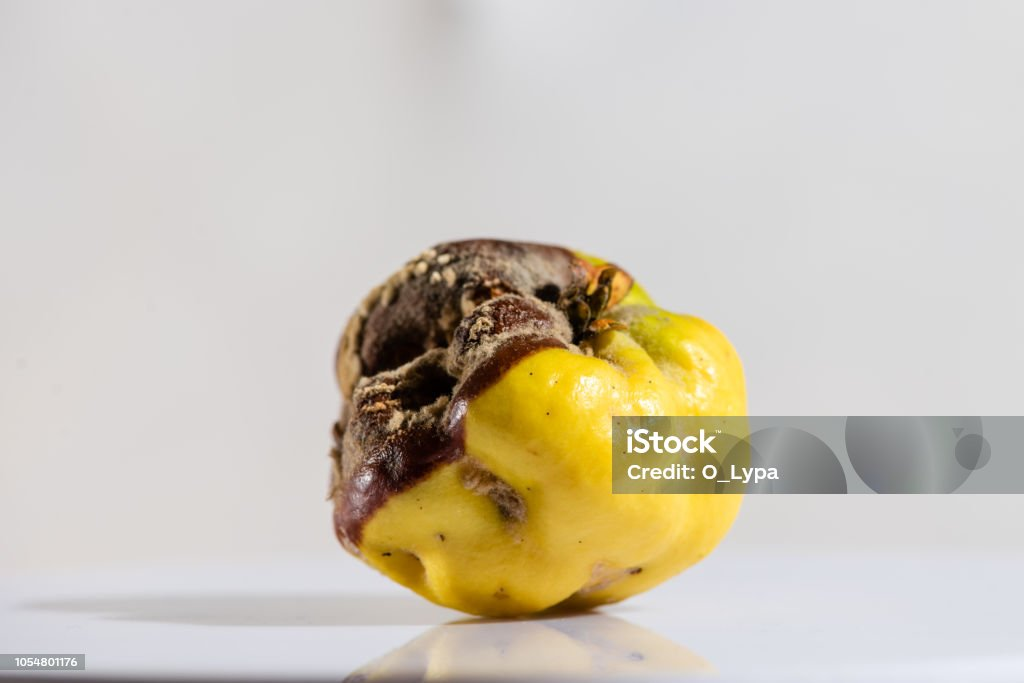

In [ ]:
test_image = 'Aple.jpg'
result = predict(test_image)
print(f"Predicted class: {result}")



import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread(test_image)
cv2_imshow(image)


Saving IMG_2371.JPG to IMG_2371.JPG
Memproses file: IMG_2371.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


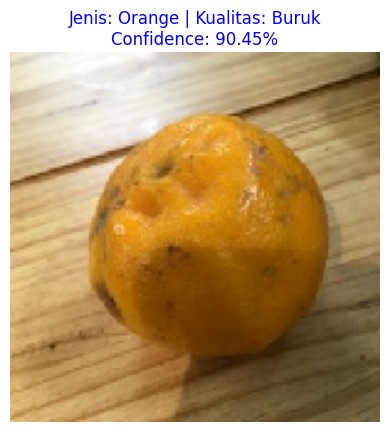

✔ Prediksi: Orange - Buruk (90.45%)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files  # Untuk Google Colab

# --- Path model yang telah dilatih dan disimpan ---
model_path = "fruit_quality_model4.h5"
IMG_SIZE = (150, 150)

# --- Daftar Kelas (Label) ---
class_names = {
    0: 'Apple_Bad', 1: 'Apple_Good', 2: 'Apple_mixed',
    3: 'Banana_Bad', 4: 'Banana_Good', 5: 'Banana_mixed',
    6: 'Guava_Bad', 7: 'Guava_Good', 8: 'Guava_mixed',
    9: 'Lemon_mixed', 10: 'Lime_Bad', 11: 'Lime_Good',
    12: 'Orange_Bad', 13: 'Orange_Good', 14: 'Orange_mixed',
    15: 'Pomegranate_Bad', 16: 'Pomegranate_Good', 17: 'Pomegranate_mixed'
}

# --- Fungsi Praproses Gambar ---
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

# --- Fungsi Prediksi ---
def predict(model, image_path):
    # Praproses gambar
    img_array, pil_img = preprocess_image(image_path)

    # Prediksi
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    confidence = float(np.max(preds))
    label = class_names.get(pred_index, "Unknown")

    # Pisahkan nama buah dan kualitas
    if "_Bad" in label:
        fruit = label.replace("_Bad", "")
        quality = "Buruk"
    elif "_Good" in label:
        fruit = label.replace("_Good", "")
        quality = "Baik"
    elif "_mixed" in label:
        fruit = label.replace("_mixed", "")
        quality = "Campuran"
    else:
        fruit = label
        quality = "Tidak Diketahui"

    # Tampilkan hasil
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title(f"Jenis: {fruit} | Kualitas: {quality}\nConfidence: {confidence:.2%}", color='blue')
    plt.show()

    return fruit, quality, confidence

# Load the model once before the loop
loaded_model = tf.keras.models.load_model(model_path)

# --- Upload dan Prediksi ---
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Memproses file: {filename}")
    fruit, quality, confidence = predict(loaded_model, filename)
    print(f"✔ Prediksi: {fruit} - {quality} ({confidence:.2%})")